In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, GlobalAveragePooling2D, GlobalMaxPooling2D, Flatten, Concatenate, Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization

from keras.applications.nasnet import NASNetLarge
from keras.applications import VGG16, VGG19

%matplotlib inline

Using TensorFlow backend.


In [3]:
from keras.layers import Dense, concatenate
from keras.models import Model, load_model

In [5]:
from src.utils.preprocess import multiple_batch_generator
from src.utils.callbacks import PlotCurves
from src.utils.load_data import load_data
from src.utils.comparams import calculate_auc, auc

### Data Preparation

In [6]:
data_dir = './data/macenko'

In [7]:
x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', 
                                               limit=None, val_limit=None, is_gzip=False, norm='macenko')
len(x_train), len(x_valid)

(261756, 32728)

In [8]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

In [8]:
del train_id
del val_id
del data_dir

# MODEL

In [7]:
dependencies = {
    'auc': auc
}

#### VGG16

In [10]:
model_vgg16 = load_model('Model/vgg16_model_bin_cross_arch_8_lr_0_001_inp96_randAug/vgg16_model_bin_cross_arch_8_lr_0_001_inp96_randAug_epoch_15.h5', custom_objects=dependencies)

W0617 02:23:26.074585 139869002719360 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 02:23:26.091273 139869002719360 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0617 02:23:26.107837 139869002719360 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0617 02:23:26.305518 139869002719360 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:174: The

In [11]:
for i, layer in enumerate(model_vgg16.layers):
    model_vgg16.layers[i].trainable = False
    model_vgg16.layers[i].name = '{}_{}'.format(layer.name, 'vgg16')

In [12]:
vgg16_out = model_vgg16.layers[-2].output

#### VGG19

In [13]:
model_vgg19 = load_model('Model/vgg19_model_bin_cross_arch_8_lr_0_001_inp96/vgg19_model_bin_cross_arch_8_lr_0_001_inp96_epoch_15.h5', custom_objects=dependencies)

In [14]:
for i, layer in enumerate(model_vgg19.layers):
    model_vgg19.layers[i].trainable = False
    model_vgg19.layers[i].name = '{}_{}'.format(layer.name, 'vgg19')

In [15]:
vgg19_out = model_vgg19.layers[-2].output

#### InceptionResnetV2

In [31]:
model_incept = load_model('Model/inception_model_bin_cross_arch_8_lr_0_001_inp96/inception_model_bin_cross_arch_8_lr_0_001_inp96_epoch_15.h5', custom_objects=dependencies)

In [32]:
for i, layer in enumerate(model_incept.layers):
    model_incept.layers[i].trainable = False
    model_incept.layers[i].name = '{}_{}'.format(layer.name, 'incept')

In [33]:
incept_out = model_incept.layers[-2].output

#### NASNET

In [18]:
import pickle

In [16]:
def build_arch_8_net():
    
    inputs = Input((96, 96, 3))
    nasnet = NASNetLarge(input_tensor=inputs, weights='imagenet', include_top=False)
    x = nasnet.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    y = Dense(2, activation='softmax')(x)
    
    # Train only the top layer
    for layer in nasnet.layers:
        layer.trainable = False

    model = Model(inputs=inputs, outputs=y)

    return model

In [17]:
nasnet_model = build_arch_8_net()

W0617 02:23:28.756882 139869002719360 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0617 02:23:29.209625 139869002719360 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.



In [25]:
with open('Model/nasnet_model_bin_cross_arch_8_lr_0_001_inp96/nasnet_model_bin_cross_arch_8_lr_0_001_inp96_weights_epoch_15.pkl', 'rb') as pkf:
    nasnet_model.set_weights(pickle.load(pkf))

In [29]:
for i, layer in enumerate(nasnet_model.layers):
    nasnet_model.layers[i].trainable = False
    nasnet_model.layers[i].name = '{}_{}'.format(layer.name, 'nasnet')

In [30]:
nasnet_out = nasnet_model.layers[-2].output

### Concatenate

In [35]:
outs = [vgg16_out, vgg19_out, incept_out, nasnet_out]

In [36]:
merge_0 = concatenate(outs)

In [38]:
x = Dense(128, activation='relu')(merge_0)
x = Dropout(0.4)(x)
output = Dense(2, activation='softmax', name='main_output')(x)

W0617 02:36:00.912199 139869002719360 deprecation.py:506] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [39]:
model = Model(inputs=[model_vgg16.input, model_vgg19.input, model_incept.input, nasnet_model.input], outputs=output)

In [40]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_incept (InputLayer)     (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1_incept (Conv2D)        (None, 47, 47, 32)   864         input_1_incept[0][0]             
__________________________________________________________________________________________________
batch_normalization_1_incept (B (None, 47, 47, 32)   96          conv2d_1_incept[0][0]            
__________________________________________________________________________________________________
activation_1_incept (Activation (None, 47, 47, 32)   0           batch_normalization_1_incept[0][0
__________________________________________________________________________________________________
conv2d_2_i

__________________________________________________________________________________________________
separable_conv_1_normal_right1_ (None, 6, 6, 336)    115920      activation_109_nasnet[0][0]      
__________________________________________________________________________________________________
separable_conv_1_normal_left2_7 (None, 6, 6, 336)    121296      activation_111_nasnet[0][0]      
__________________________________________________________________________________________________
separable_conv_1_normal_right2_ (None, 6, 6, 336)    115920      activation_113_nasnet[0][0]      
__________________________________________________________________________________________________
separable_conv_1_normal_left5_7 (None, 6, 6, 336)    115920      activation_115_nasnet[0][0]      
__________________________________________________________________________________________________
activation_153_incept (Activati (None, 4, 4, 192)    0           batch_normalization_153_incept[0]
__________

### Compile

In [42]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_auc', 
                                            patience=2,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000005)

In [43]:
optimizer = Adam(lr=0.0001)
loss = 'binary_crossentropy'
metrics = ['acc', auc]

In [44]:
model.compile(optimizer, loss, metrics)

## Data Generator

In [45]:
model_name = 'ensemble_2_model_bin_cross_arch_15_lr_0_0001_inp96'

In [46]:
generator_num = len(outs)

In [47]:
# Define batch size.
batch_size = 128
n_epoch = 15

# Parameters for generators
train_params = {
    'dim': (96, 96),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': True,
}

val_params = {
    'dim': (96, 96),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': False,
}

# Generators
training_generator = multiple_batch_generator(generator_num, list_IDs=partition['train'],
                                              data=x_train, labels=train_labels, **train_params)
validation_generator = multiple_batch_generator(generator_num, list_IDs=partition['validation'],
                                                data=x_valid, labels=val_labels, **val_params)


In [59]:
# Callbacks,
callbacks = [PlotCurves(model_name=model_name), learning_rate_reduction]

### Load Model

In [8]:
model = load_model('./Model/ensemble_2_model_bin_cross_arch_15_lr_0_0001_inp96/ensemble_2_model_bin_cross_arch_15_lr_0_0001_inp96_epoch_4.h5',
                   custom_objects=dependencies)

W0617 22:02:19.206721 140562649530496 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0617 22:02:19.337059 140562649530496 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0617 22:02:19.352407 140562649530496 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0617 22:02:19.352886 140562649530496 deprecation_wrapper.py:119] From /home/aorus/workspaces/simge/PatchCamelyon/.env/lib/python3.6/site-packages/keras/backend/tensorflow_

In [9]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1_incept (InputLayer)     (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1_incept (Conv2D)        (None, 47, 47, 32)   864         input_1_incept[0][0]             
__________________________________________________________________________________________________
batch_normalization_1_incept (B (None, 47, 47, 32)   96          conv2d_1_incept[0][0]            
__________________________________________________________________________________________________
activation_1_incept (Activation (None, 47, 47, 32)   0           batch_normalization_1_incept[0][0
__________________________________________________________________________________________________
conv2d_2_i

separable_conv_1_bn_normal_righ (None, 12, 12, 168)  672         separable_conv_1_normal_right2_5_
__________________________________________________________________________________________________
separable_conv_1_bn_normal_left (None, 12, 12, 168)  672         separable_conv_1_normal_left5_5_n
__________________________________________________________________________________________________
activation_147_incept (Activati (None, 4, 4, 160)    0           batch_normalization_147_incept[0]
__________________________________________________________________________________________________
activation_85_nasnet (Activatio (None, 12, 12, 168)  0           separable_conv_1_bn_normal_left1_
__________________________________________________________________________________________________
activation_87_nasnet (Activatio (None, 12, 12, 168)  0           separable_conv_1_bn_normal_right1
__________________________________________________________________________________________________
activation

### Fit Generator

In [60]:
steps = int(len(y_train)/batch_size)
val_steps= int(len(y_valid)/batch_size)

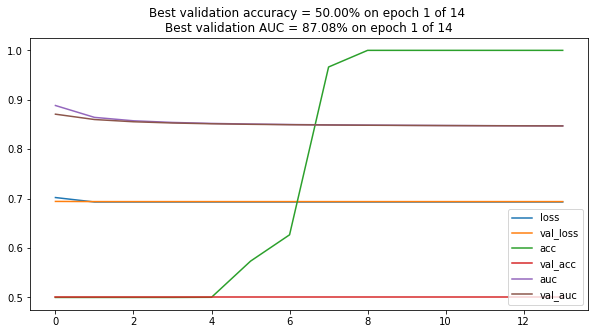

In [61]:
# Training with learning 
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks, steps_per_epoch=steps, validation_steps=val_steps)

## Test

In [10]:
x_test, y_test_true = load_data('data/macenko', purpose='test', is_gzip=True, norm='macenko')

# indexes
test_id = np.arange(len(x_test))

# create a useful dictionary structures
partition = {}
partition['test'] = test_id
    
test_labels = {str(i) : y_test_true[i].flatten()[0] for i in test_id}

In [13]:
generator_num = 4
batch_size = 128

In [14]:
test_params = {
    'dim': (96, 96),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug' : False
}

# Generators
test_generator = multiple_batch_generator(generator_num, list_IDs=partition['test'], 
                                          data=x_test, labels=test_labels, **test_params)

In [15]:
test_steps = int(len(test_labels)/batch_size)

In [16]:
preds = model.predict_generator(test_generator, steps=test_steps)

In [17]:
true_labels = np.array(y_test_true).flatten()
pred_labels = np.array([p[1] for p in preds])
calculate_auc(true_labels, pred_labels)

sklearn auc: 0.8614463907140238
tf auc: [0.8611405, 0.8611405]


In [18]:
with open(os.path.join('/home/aorus', 'preds_ensemble_2_model_bin_cross_arch_15_lr_0_0001_inp96.csv'), 'w') as f:
    f.write("case, prediction\n")
    for i, p in enumerate(preds):
        f.write(str(i) + ',' + str(p[1]) + '\n')